# Experiment 8: Final Accuracy Comparison

**Goal:** Compare GSM8K accuracy with different temperature strategies under noise.

**Strategies:**
1. T = T_base (no noise correction)
2. T = constant T* (using mean α)
3. T = dynamic T*(t) (using fitted α(t))

**Formula:**
- Constant: $T^* = T_{base} \cdot \sqrt{1 + \alpha_{mean}}$
- Dynamic: $T^*(t) = T_{base} \cdot \sqrt{1 + 0.427 \cdot e^{-0.024t} + 0.095}$

In [1]:
# ============================================================
# IMPORTS & UTILITIES
# ============================================================

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
import re
from transformers import AutoModelForCausalLM, AutoTokenizer
from contextlib import contextmanager
from datasets import load_dataset
from tqdm import tqdm

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def extract_answer(text):
    """Extract numerical answer from model output."""
    # Look for #### pattern (GSM8K format)
    match = re.search(r'####\s*([\d,\.\-]+)', text)
    if match:
        return match.group(1).replace(',', '')
    
    # Look for 'answer is X' pattern
    match = re.search(r'answer is[:\s]*([\d,\.\-]+)', text.lower())
    if match:
        return match.group(1).replace(',', '')
    
    # Look for boxed answer (common in reasoning models)
    match = re.search(r'\\boxed\{([\d,\.\-]+)\}', text)
    if match:
        return match.group(1).replace(',', '')
    
    # Look for last number in text
    numbers = re.findall(r'[\d,]+\.?\d*', text)
    if numbers:
        return numbers[-1].replace(',', '')
    
    return None
    
# def extract_answer(text):
#     """Extract numerical answer from model response."""
#     boxed = re.findall(r'\\boxed\{([^}]+)\}', text)
#     if boxed:
#         nums = re.findall(r'-?[\d,]+\.?\d*', boxed[-1].replace(',', ''))
#         if nums:
#             return nums[-1]
    
#     patterns = [
#         r'answer is[:\s]*\$?(-?[\d,]+\.?\d*)',
#         r'=\s*\$?(-?[\d,]+\.?\d*)\s*$',
#         r'\$(-?[\d,]+\.?\d*)\s*$',
#     ]
#     for pattern in patterns:
#         match = re.search(pattern, text.replace(',', ''), re.IGNORECASE | re.MULTILINE)
#         if match:
#             return match.group(1)
    
#     nums = re.findall(r'-?[\d,]+\.?\d*', text.replace(',', ''))
#     return nums[-1] if nums else ''

def extract_ground_truth(answer_text):
    match = re.search(r'####\s*(-?[\d,]+\.?\d*)', answer_text.replace(',', ''))
    return match.group(1) if match else ''

def check_answer(pred, truth):
    if not pred or not truth:
        return False
    try:
        return abs(float(pred) - float(truth)) < 1e-5
    except:
        return pred.strip() == truth.strip()

@contextmanager
def activation_noise_context(model, noise_scale):
    handles = []
    
    def make_hook(scale):
        def hook(module, args, kwargs):
            if len(args) > 0:
                x = args[0]
                noise = torch.randn_like(x) * scale * x.std()
                noisy_x = x + noise
                return (noisy_x,) + args[1:], kwargs
            return args, kwargs
        return hook
    
    try:
        for name, module in model.named_modules():
            if isinstance(module, torch.nn.Linear):
                handle = module.register_forward_pre_hook(make_hook(noise_scale), with_kwargs=True)
                handles.append(handle)
        yield model, handles
    finally:
        for handle in handles:
            handle.remove()

print("Imports loaded!")

Imports loaded!


In [2]:
# ============================================================
# CONFIGURATION
# ============================================================

SEED = 42
set_seed(SEED)

NUM_EXAMPLES = 20  # Use 50 for meaningful statistics

# From previous experiments
T_BASE = 0.8
NOISE_SCALE = 0.05

# Fitted α(t) parameters from Experiment 6
ALPHA_A = 0.427   # initial amplitude
ALPHA_B = 0.024   # decay rate
ALPHA_C = 0.095   # floor

# Mean α (from integral)
ALPHA_MEAN = 0.21


# Constant T*
T_STAR_CONST = T_BASE * np.sqrt(1 + ALPHA_MEAN)

print(f"T_base = {T_BASE}")
print(f"Noise scale = {NOISE_SCALE}")
print(f"α_mean = {ALPHA_MEAN}")
print(f"T*_const = {T_STAR_CONST:.3f}")
print(f"α(t) = {ALPHA_A} × exp(-{ALPHA_B}×t) + {ALPHA_C}")

T_base = 0.8
Noise scale = 0.05
α_mean = 0.21
T*_const = 0.880
α(t) = 0.427 × exp(-0.024×t) + 0.095


In [3]:
# ============================================================
# LOAD MODEL
# ============================================================

MODEL_NAME = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"

print(f"Loading {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float32,
    device_map="auto"
)
model.eval()
print(f"Model loaded on {model.device}")

Loading deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


Model loaded on cuda:0


In [4]:
# ============================================================
# LOAD GSM8K
# ============================================================

gsm8k = load_dataset('gsm8k', 'main', split='test')
print(f"GSM8K loaded: {len(gsm8k)} examples")

test_examples = [gsm8k[i] for i in range(NUM_EXAMPLES)]

print(f"Using {NUM_EXAMPLES} examples")

GSM8K loaded: 1319 examples
Using 20 examples


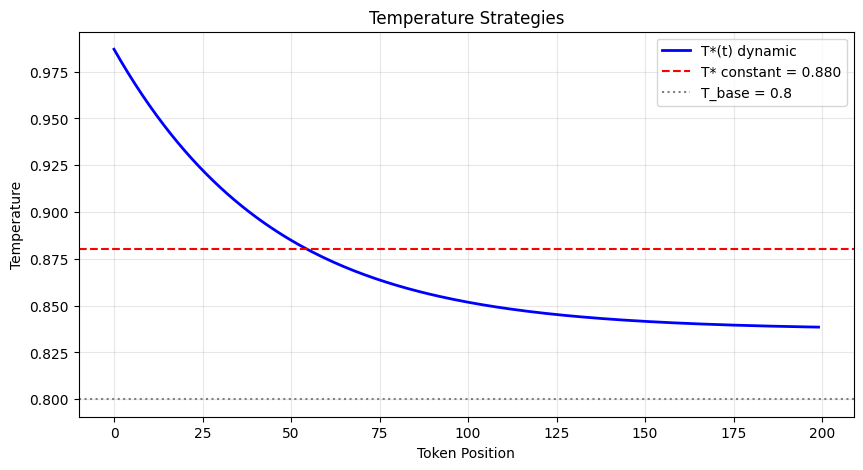

T*(0) = 0.987
T*(50) = 0.885
T*(150) = 0.842


In [5]:
# ============================================================
# TEMPERATURE FUNCTIONS
# ============================================================

def alpha_t(t):
    """Dynamic α as function of position."""
    return ALPHA_A * np.exp(-ALPHA_B * t) + ALPHA_C

def t_star_dynamic(t):
    """Dynamic T* as function of position."""
    return T_BASE * np.sqrt(1 + alpha_t(t))

# Visualize
positions = np.arange(0, 200)
t_stars = [t_star_dynamic(t) for t in positions]

plt.figure(figsize=(10, 5))
plt.plot(positions, t_stars, 'b-', linewidth=2, label='T*(t) dynamic')
plt.axhline(y=T_STAR_CONST, color='r', linestyle='--', label=f'T* constant = {T_STAR_CONST:.3f}')
plt.axhline(y=T_BASE, color='gray', linestyle=':', label=f'T_base = {T_BASE}')
plt.xlabel('Token Position')
plt.ylabel('Temperature')
plt.title('Temperature Strategies')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"T*(0) = {t_star_dynamic(0):.3f}")
print(f"T*(50) = {t_star_dynamic(50):.3f}")
print(f"T*(150) = {t_star_dynamic(150):.3f}")

In [6]:
# ============================================================
# GENERATION FUNCTIONS
# ============================================================

def generate_with_noise_constant_T(model, tokenizer, prompt, noise_scale, temperature, 
                                    max_new_tokens=1024, seed=None):
    """Generate with constant temperature under noise."""
    if seed is not None:
        set_seed(seed)
    
    inputs = tokenizer(prompt, return_tensors='pt').to(model.device)
    input_ids = inputs.input_ids.clone()
    
    with activation_noise_context(model, noise_scale) as (noisy_model, _):
        for _ in range(max_new_tokens):
            with torch.no_grad():
                outputs = noisy_model(input_ids)
                logits = outputs.logits[0, -1, :].float()
            
            probs = F.softmax(logits / temperature, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1).item()
            input_ids = torch.cat([input_ids, torch.tensor([[next_token]]).to(model.device)], dim=1)
            
            if next_token == tokenizer.eos_token_id:
                break
    
    response = tokenizer.decode(input_ids[0, inputs.input_ids.shape[1]:], skip_special_tokens=True)
    return response


def generate_with_noise_dynamic_T(model, tokenizer, prompt, noise_scale,
                                   max_new_tokens=1024, seed=None):
    """Generate with dynamic T*(t) under noise."""
    if seed is not None:
        set_seed(seed)
    
    inputs = tokenizer(prompt, return_tensors='pt').to(model.device)
    input_ids = inputs.input_ids.clone()
    
    with activation_noise_context(model, noise_scale) as (noisy_model, _):
        for t in range(max_new_tokens):
            with torch.no_grad():
                outputs = noisy_model(input_ids)
                logits = outputs.logits[0, -1, :].float()
            
            # Dynamic temperature!
            temp_t = t_star_dynamic(t)
            probs = F.softmax(logits / temp_t, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1).item()
            input_ids = torch.cat([input_ids, torch.tensor([[next_token]]).to(model.device)], dim=1)
            
            if next_token == tokenizer.eos_token_id:
                break
    
    response = tokenizer.decode(input_ids[0, inputs.input_ids.shape[1]:], skip_special_tokens=True)
    return response

In [7]:
# ============================================================
# RUN EVALUATION
# ============================================================

print("Running evaluation...")
print("="*70)

results = {
    'T_base': {'correct': 0, 'total': 0},
    'T_const': {'correct': 0, 'total': 0},
    'T_dynamic': {'correct': 0, 'total': 0},
}

for i, ex in enumerate(tqdm(test_examples)):
    question = ex['question']
    ground_truth = extract_ground_truth(ex['answer'])
    
    messages = [{"role": "user", "content": f"Solve this math problem step by step:\n{question}"}]
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    
    # Strategy 1: T = T_base (no correction)
    set_seed(SEED + i*100)
    response = generate_with_noise_constant_T(
        model, tokenizer, prompt, NOISE_SCALE, T_BASE, seed=SEED+ i*100
    )
    pred = extract_answer(response)
    results['T_base']['total'] += 1
    if check_answer(pred, ground_truth):
        results['T_base']['correct'] += 1
    
    # Strategy 2: T = constant T*
    set_seed(SEED+ i*100)
    response = generate_with_noise_constant_T(
        model, tokenizer, prompt, NOISE_SCALE, T_STAR_CONST, seed=SEED+ i*100
    )
    pred = extract_answer(response)
    results['T_const']['total'] += 1
    if check_answer(pred, ground_truth):
        results['T_const']['correct'] += 1
    
    # Strategy 3: T = dynamic T*(t)
    set_seed(SEED+ i*100)
    response = generate_with_noise_dynamic_T(
        model, tokenizer, prompt, NOISE_SCALE, seed=SEED+ i*100
    )
    pred = extract_answer(response)
    results['T_dynamic']['total'] += 1
    if check_answer(pred, ground_truth):
        results['T_dynamic']['correct'] += 1
    
    # Progress update every 10
    if (i + 1) % 10 == 0:
        print(f"\n[{i+1}/{NUM_EXAMPLES}] Current accuracies:")
        for name, r in results.items():
            acc = r['correct'] / r['total'] if r['total'] > 0 else 0
            print(f"  {name}: {acc:.1%}")

print("\nDone!")

Running evaluation...


 50%|█████     | 10/20 [2:03:03<1:58:40, 712.03s/it]


[10/20] Current accuracies:
  T_base: 40.0%
  T_const: 30.0%
  T_dynamic: 30.0%


100%|██████████| 20/20 [3:38:40<00:00, 656.00s/it]  


[20/20] Current accuracies:
  T_base: 40.0%
  T_const: 35.0%
  T_dynamic: 45.0%

Done!


In [8]:
# ============================================================
# RESULTS SUMMARY
# ============================================================

print("\n" + "="*70)
print("FINAL RESULTS: GSM8K Accuracy with Different Temperature Strategies")
print("="*70)
print(f"\nNoise scale: {NOISE_SCALE}")
print(f"Number of examples: {NUM_EXAMPLES}")
print(f"\n{'Strategy':<20} {'Temperature':<20} {'Accuracy':<15} {'Correct'}")
print("-"*70)

strategies = [
    ('T_base', f'T = {T_BASE} (no correction)'),
    ('T_const', f'T* = {T_STAR_CONST:.3f} (constant)'),
    ('T_dynamic', 'T*(t) = dynamic'),
]

for name, desc in strategies:
    r = results[name]
    acc = r['correct'] / r['total'] if r['total'] > 0 else 0
    print(f"{desc:<40} {acc:<15.1%} {r['correct']}/{r['total']}")

# Improvement
acc_base = results['T_base']['correct'] / results['T_base']['total']
acc_const = results['T_const']['correct'] / results['T_const']['total']
acc_dynamic = results['T_dynamic']['correct'] / results['T_dynamic']['total']

print("\n" + "-"*70)
print(f"Improvement from T_base to T*_const: {(acc_const - acc_base)*100:+.1f}%")
print(f"Improvement from T_base to T*_dynamic: {(acc_dynamic - acc_base)*100:+.1f}%")
print(f"Improvement from T*_const to T*_dynamic: {(acc_dynamic - acc_const)*100:+.1f}%")


FINAL RESULTS: GSM8K Accuracy with Different Temperature Strategies

Noise scale: 0.05
Number of examples: 20

Strategy             Temperature          Accuracy        Correct
----------------------------------------------------------------------
T = 0.8 (no correction)                  40.0%           8/20
T* = 0.880 (constant)                    35.0%           7/20
T*(t) = dynamic                          45.0%           9/20

----------------------------------------------------------------------
Improvement from T_base to T*_const: -5.0%
Improvement from T_base to T*_dynamic: +5.0%
Improvement from T*_const to T*_dynamic: +10.0%


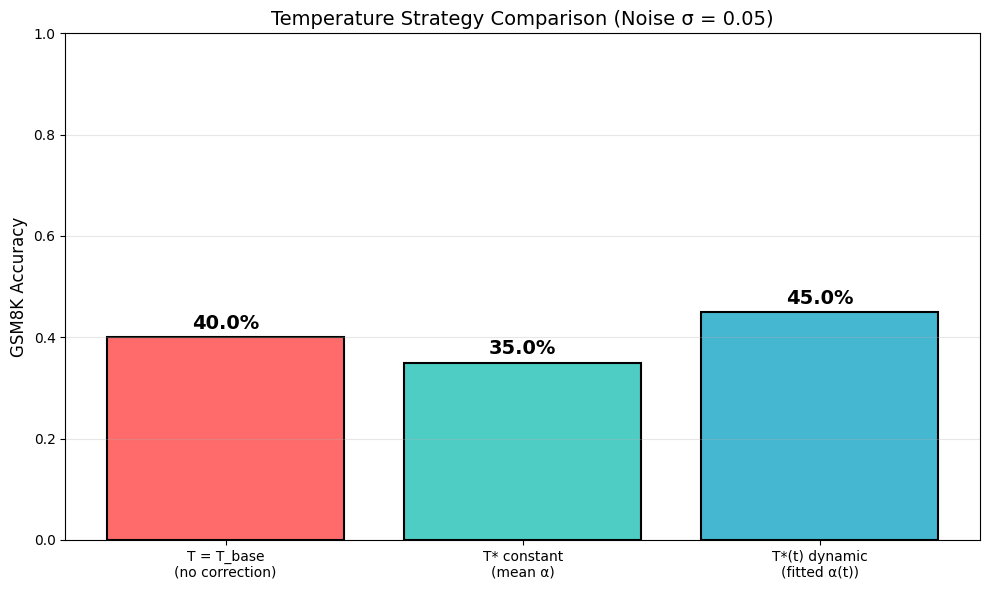

In [9]:
# ============================================================
# PLOT RESULTS
# ============================================================

fig, ax = plt.subplots(figsize=(10, 6))

names = ['T = T_base\n(no correction)', 'T* constant\n(mean α)', 'T*(t) dynamic\n(fitted α(t))']
accs = [acc_base, acc_const, acc_dynamic]
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']

bars = ax.bar(names, accs, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels
for bar, acc in zip(bars, accs):
    height = bar.get_height()
    ax.annotate(f'{acc:.1%}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=14, fontweight='bold')

ax.set_ylabel('GSM8K Accuracy', fontsize=12)
ax.set_title(f'Temperature Strategy Comparison (Noise σ = {NOISE_SCALE})', fontsize=14)
ax.set_ylim(0, 1.0)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('temperature_strategy_comparison.png', dpi=150)
plt.show()

In [10]:
# ============================================================
# CLEAN MODEL BASELINE
# ============================================================

print("Running clean model baseline...")
print("="*70)

clean_correct = 0

for i, ex in enumerate(tqdm(test_examples)):
    question = ex['question']
    ground_truth = extract_ground_truth(ex['answer'])
    
    messages = [{"role": "user", "content": f"Solve this math problem step by step:\n{question}"}]
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    
    set_seed(SEED + i*100)
    inputs = tokenizer(prompt, return_tensors='pt').to(model.device)
    input_ids = inputs.input_ids.clone()
    
    # No noise!
    for _ in range(1024):
        with torch.no_grad():
            outputs = model(input_ids)
            logits = outputs.logits[0, -1, :].float()
        
        probs = F.softmax(logits / T_BASE, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1).item()
        input_ids = torch.cat([input_ids, torch.tensor([[next_token]]).to(model.device)], dim=1)
        
        if next_token == tokenizer.eos_token_id:
            break
    
    response = tokenizer.decode(input_ids[0, inputs.input_ids.shape[1]:], skip_special_tokens=True)
    pred = extract_answer(response)
    
    if check_answer(pred, ground_truth):
        clean_correct += 1

acc_clean = clean_correct / NUM_EXAMPLES
print(f"\nClean model accuracy (T = {T_BASE}): {acc_clean:.1%}")

Running clean model baseline...


100%|██████████| 20/20 [33:12<00:00, 99.61s/it] 


Clean model accuracy (T = 0.8): 55.0%


In [11]:
# ============================================================
# FINAL SUMMARY WITH CLEAN BASELINE
# ============================================================

print("\n" + "="*70)
print("COMPLETE RESULTS SUMMARY")
print("="*70)

print(f"\n{'Model/Strategy':<45} {'Accuracy':<15}")
print("-"*60)
print(f"{'Clean model (no noise), T = T_base':<45} {acc_clean:<15.1%}")
print("-"*60)
print(f"{'Noisy model, T = T_base (no correction)':<45} {acc_base:<15.1%}")
print(f"{'Noisy model, T* = constant':<45} {acc_const:<15.1%}")
print(f"{'Noisy model, T*(t) = dynamic':<45} {acc_dynamic:<15.1%}")
print("-"*60)

print(f"\nKey findings:")
print(f"  • Noise degrades accuracy: {acc_clean:.1%} → {acc_base:.1%} ({(acc_base-acc_clean)*100:+.1f}%)")
print(f"  • Constant T* recovers: {acc_base:.1%} → {acc_const:.1%} ({(acc_const-acc_base)*100:+.1f}%)")
print(f"  • Dynamic T*(t) further improves: {acc_const:.1%} → {acc_dynamic:.1%} ({(acc_dynamic-acc_const)*100:+.1f}%)")

if acc_dynamic > acc_clean:
    print(f"\n  ★ Dynamic T*(t) EXCEEDS clean model! ({acc_dynamic:.1%} vs {acc_clean:.1%})")


COMPLETE RESULTS SUMMARY

Model/Strategy                                Accuracy       
------------------------------------------------------------
Clean model (no noise), T = T_base            55.0%          
------------------------------------------------------------
Noisy model, T = T_base (no correction)       40.0%          
Noisy model, T* = constant                    35.0%          
Noisy model, T*(t) = dynamic                  45.0%          
------------------------------------------------------------

Key findings:
  • Noise degrades accuracy: 55.0% → 40.0% (-15.0%)
  • Constant T* recovers: 40.0% → 35.0% (-5.0%)
  • Dynamic T*(t) further improves: 35.0% → 45.0% (+10.0%)


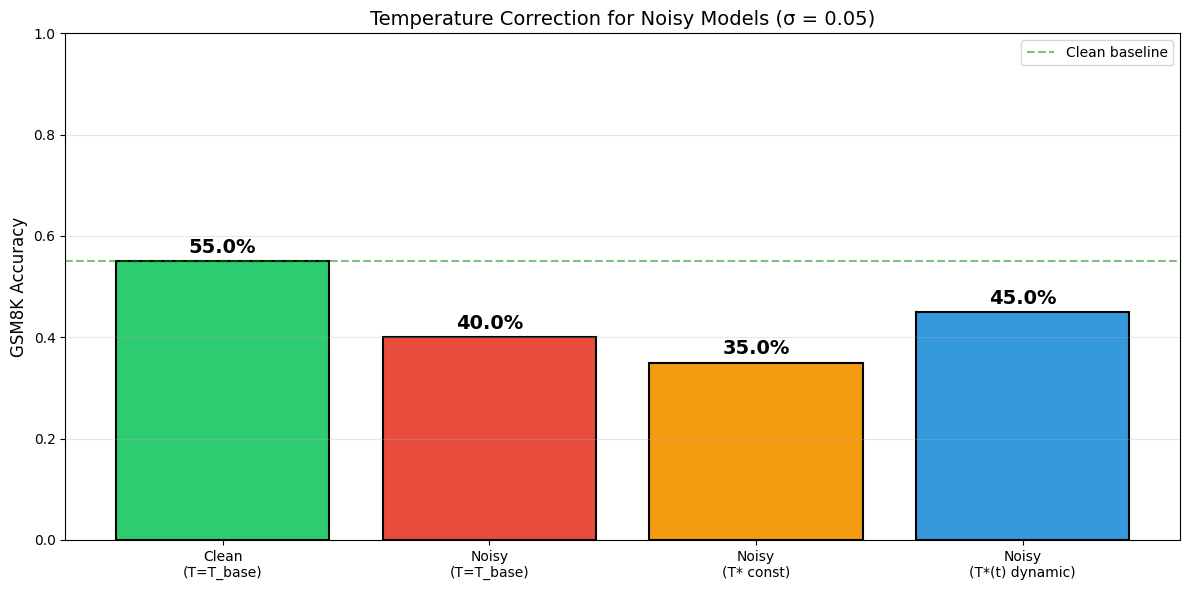

In [12]:
# ============================================================
# FINAL BAR CHART
# ============================================================

fig, ax = plt.subplots(figsize=(12, 6))

names = ['Clean\n(T=T_base)', 'Noisy\n(T=T_base)', 'Noisy\n(T* const)', 'Noisy\n(T*(t) dynamic)']
accs = [acc_clean, acc_base, acc_const, acc_dynamic]
colors = ['#2ecc71', '#e74c3c', '#f39c12', '#3498db']

bars = ax.bar(names, accs, color=colors, edgecolor='black', linewidth=1.5)

for bar, acc in zip(bars, accs):
    height = bar.get_height()
    ax.annotate(f'{acc:.1%}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=14, fontweight='bold')

ax.axhline(y=acc_clean, color='green', linestyle='--', alpha=0.5, label='Clean baseline')

ax.set_ylabel('GSM8K Accuracy', fontsize=12)
ax.set_title(f'Temperature Correction for Noisy Models (σ = {NOISE_SCALE})', fontsize=14)
ax.set_ylim(0, 1.0)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('final_accuracy_comparison.png', dpi=150)
plt.show()